# CatBoost

<div class="alert alert-info">
    

**`CatBoost`** — это open-source библиотека градиентного бустинга на решающих деревьях с поддержкой категориальных фичей из коробки, преемник алгоритма `MatrixNet`, разработанного Яндексом.<br>
В плане простоты использования и легкости входа для новичков, пожалуй, является топ-1 библиотекой для табличных данных и вот почему:
* **Принимает категориальные фичи** сразу без всякой предварительной обработки.
* Чтобы перенести обучение с **`CPU`** на **`GPU`** достаточно поменять значение 1 параметра, без установки доп.пакетов или специальных версий, как в других библиотеках
* Даже с дефолтными параметрами выдает хорошую точность модели
  * Основные параметры не константные, а **подбираются самой библиотекой**, в зависимости от размера входных данных.
* Может принимать текстовые признаки, эмбеддинги, временные признаки.
* Без дополнительных манипуляций и оберток встраивается в стандартные пайплайны (например, `sklearn`).
* Идет в комплекте с "батарейками": `feature_selection`, `object_selection`, `cross_validation`, `grid_search` и пр.

<div class="alert alert-info">

**Из минусов: (почти нет)**
* Не умеет обрабатывать пропуски в данных (Сами избавляемся или заполняем `NaN` перед подачей в модель).
* Не все метрики и лоссы доступны при обучении на **`GPU`**.
* Не умеет делать кофе 

<div class="alert alert-info">

**В общем и целом, рекомендуем начинать всегда именно с этой библиотеки, особенно, если только начинаете вкатываться в соревнования.<br>
Алгоритм примерно следующий:**

1. Скачали данные
2. Провели быстрый EDA
3. Собрали список кат-фичей, закинули данные в **`CatBoost`**
4. Посмотрели, что модель дает с дефолтными фичами и параметрами. (baseline)
5. Отправили сабмишен на лидерборд.
6. Начинаем настройку валидации, **feature engeneering**, **тюнинг модели**, прочие манипуляции и танцы с бубном.

In [1]:
!pip install seaborn catboost -q

import numpy as np
import pandas as pd

# Импортируем `train` датасет

train (2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
377,p22837387w,VW Tiguan,economy,petrol,3.76,2017,131667,2017,28.24,engine_fuel,4.442989,1.789417e+07,0.1,172.462229,-2.966362,174,169
139,a-7125351Z,VW Tiguan,economy,petrol,3.62,2017,127194,2020,69.56,engine_ignition,4.050115,1.286971e+07,0.1,167.517233,-1.042707,174,173
110,t89744603y,Smart ForFour,economy,petrol,2.36,2017,109830,2018,79.14,another_bug,4.886264,7.158549e+06,0.1,196.000000,8.058148,174,170


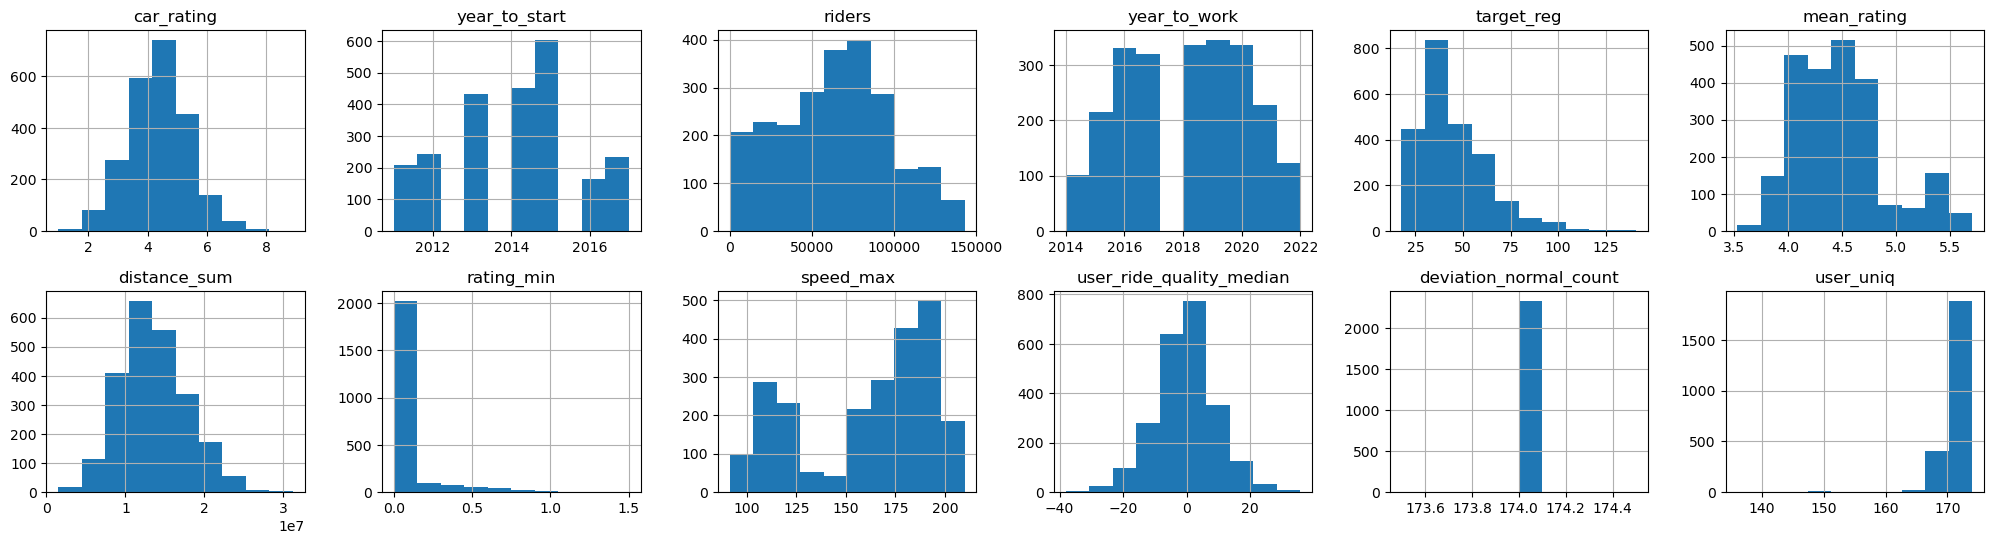

In [3]:
path = "quickstart_train.csv"
train = pd.read_csv(path)

print("train", train.shape)
train.hist(figsize=(25, 6), layout=(-1, 6))
train.sample(3)

# Группируем признаки и отбираем категориальные

In [4]:
cat_features = ["model", "car_type", "fuel_type"]  # Выделяем категориальные признаки
targets = ["target_class", "target_reg"]
features2drop = ["car_id"]  # эти фичи будут удалены

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 11
targets ['target_class', 'target_reg']


# **`CatBoost`** **`Classifier`** и его параметры

<p id="c1"></p>    
<div class="alert alert-info">

Задача - использовать  **`CatBoost`** для классификации поломок. Посмотрим, сможет ли алгоритм справиться с поставленной задачей.

In [5]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [6]:
# Какие параметры есть в Catboost? посмотрим через shift + Tab
CatBoostClassifier()

<div class="alert alert-info">
    
**Базовые параметры**
    
* `iterations` (синонимы `num_boost_round`, `n_estimators`, `num_trees`) - максимальное количество деревьев, используемых в модели (по умолчанию **`1000`**). <br>
    Значение может быть ниже заданного, если используются другие параметры, накладывающие ограничение на количество деревьев;
* `learning_rate` или `eta` – скорость обучения, которая определяет, насколько быстро или медленно модель будет учиться. Значение по умолчанию обычно равно **`0.03`**.
* `depth (max_depth)` - глубина дерева (по умолчанию 6, максимальное значение - 16); 
* `cat_features` - список наименований категориальных признаков; 

**Режим обучения**

* `loss_function` или `objective`- функция потерь, которую надо минимизировать при обучении. Есть показатели для регрессии (среднеквадратичная ошибка), есть для классификации (`logloss`).
* `eval_metric` - валидационная метрика, используемая для обнаружения переобучения и ранней остановки;
* `custom_metric` - отслеживаемые метрики. Лучшие метрики в процессе обучения можно вернуть методом `get_best_score`;
* `early_stopping_rounds` - определяет число итераций до остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `use_best_model` - если **`True`**, в результате обучения с ранней остановкой будет возвращаться модель, полученная на итерации (количеством деревьев) с лучшей метрикой на валидационной выборке;

<div class="alert alert-info">
    
**Регуляризация модели, ускоряющие и обобщающие модель**
    
* `l2_leaf_reg` (или `reg_lambda`) – коэффициент при члене регуляризации **`L2`** функции потерь. Значение по умолчанию – **`3.0`**.
* `min_data_in_leaf (min_child_samples)` -  минимальное количество обучающих сэмплов в листе. 
* `max_leaves (num_leaves)` - максимальное количество листьев в дереве. 
* `subsample` - часть исходной выборки, отбираемая для обучения каждого дерева;
* `colsample_bylevel` - доля признаков, используемая для отбора на каждом сплите;
* `max_bin` - максимальное число бинов, на которые разбиваются признаки

**Полезно использовать**    
    
* `random_seed` или `random_state` – инициализирующее значение для используемого генератора случайных чисел, чтобы обеспечить воспроизводимость эксперимента;
* `task_type` - используемое для вычислений устройство (**`CPU`**, **`GPU`**);
* `thread_count` - число используемых для обучения потоков (по умолчанию = **`-1`**, что означает - все ядра процессора);
* `verbose` - объем выводимой информации (**`False`** - подавляем сообщения).

<div class="alert alert-info">

**Балансировка классов**

* `class_weights` - веса классов в моделях классификации. Используется для устранения дисбаланса (например, вес `positive`= `количество_negative`/`количество_positive`);
* `classes_count` - количество классов для многоклассовой классификации;
* `auto_class_weights` - устраняет дисбаланс автоматически (значения - **`Balanced`**, **`SqrtBalanced`**);
* `scale_pos_weight` - задает вес для положительного класса; Среди параметров `scale_pos_weight`, `auto_class_weights`, `class_weights` одновременно используется только один.

## Для начала обучим **`CatBoost`** с параметрами по умолчанию:

In [7]:
from sklearn.model_selection import train_test_split

X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.8108068	test: 1.8310378	best: 1.8310378 (0)	total: 79.9ms	remaining: 1m 19s
200:	learn: 0.2789378	test: 0.5441162	best: 0.5374049 (156)	total: 6.11s	remaining: 24.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5374048663
bestIteration = 156

Shrink model to first 157 iterations.


<div class="alert alert-info">
    
Видим, что **`CatBoost`** сам установил параметр `learning_rate = 0.109335` <br>
Теперь давайте поменяем количество деревьев.

In [9]:
clf = CatBoostClassifier(iterations=100,
                         thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=10,
    use_best_model=True,
    early_stopping_rounds=50,
)

Learning rate set to 0.263488
0:	learn: 1.5180267	test: 1.5292177	best: 1.5292177 (0)	total: 22.1ms	remaining: 2.19s
10:	learn: 0.5942287	test: 0.6609974	best: 0.6609974 (10)	total: 241ms	remaining: 1.95s
20:	learn: 0.5086990	test: 0.6046452	best: 0.6046452 (20)	total: 457ms	remaining: 1.72s
30:	learn: 0.4489243	test: 0.5761154	best: 0.5761154 (30)	total: 706ms	remaining: 1.57s
40:	learn: 0.4020685	test: 0.5688007	best: 0.5684894 (33)	total: 963ms	remaining: 1.39s
50:	learn: 0.3600712	test: 0.5740101	best: 0.5681639 (46)	total: 1.2s	remaining: 1.16s
60:	learn: 0.3375750	test: 0.5737759	best: 0.5681639 (46)	total: 1.41s	remaining: 905ms
70:	learn: 0.3129667	test: 0.5697338	best: 0.5678971 (68)	total: 1.64s	remaining: 671ms
80:	learn: 0.2922667	test: 0.5678989	best: 0.5657195 (76)	total: 1.92s	remaining: 450ms
90:	learn: 0.2685586	test: 0.5679290	best: 0.5657195 (76)	total: 2.17s	remaining: 214ms
99:	learn: 0.2537216	test: 0.5724496	best: 0.5657195 (76)	total: 2.36s	remaining: 0us

bestT

<div class="alert alert-info">
    
Число деревьев уменьшили вдвое и `learning_rate` тоже пересчитался - стал больше: `0.14248`. Он также зависит не только от числа деревьев, но и пересчитывается под размеры датасета - это одна из крутых фишек CatBoost, и поэтому он может выдавать хорошую точность из коробки. Чтобы посмотреть другие гиперпараметры модели и как они меняются, можно вызвать метод: `clf.get_all_params()`

In [11]:
# Посмотрим на feature importance с помощью встроенного метода
# Не забываем про параметр prettified, чтобы список вывелся в виде красивой таблицы
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,34.336544
1,mean_rating,34.158117
2,rating_min,13.206289
3,model,4.214882
4,user_uniq,2.792148
5,car_type,2.422167
6,user_ride_quality_median,2.215881
7,distance_sum,2.068688
8,riders,1.730535
9,year_to_work,1.185616


# Настраиваем обучение по фолдам

In [12]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import KFold  # k-фолдная валидация

In [13]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# параметры валидации, обучение будет идти на n_splits фолдах
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения 
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostClassifier(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        loss_function="MultiClass",  # MultiLogloss
        # eval_metric = 'Precision',  F1:macro / AUC:hints=skip_train~false
        custom_metric=["Recall"],  # 'AUC / Accuracy,
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=7575,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "Recall" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean Recall score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 2.1956073	test: 2.1958090	best: 2.1958090 (0)	total: 2.32ms	remaining: 8.12s
500:	learn: 0.4702692	test: 0.5569354	best: 0.5569354 (500)	total: 1.11s	remaining: 6.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5096496804
bestIteration = 916

Shrink model to first 917 iterations.
0:	learn: 2.1951404	test: 2.1964014	best: 2.1964014 (0)	total: 2.42ms	remaining: 8.48s
500:	learn: 0.4909194	test: 0.5563577	best: 0.5562080 (497)	total: 1.08s	remaining: 6.46s
1000:	learn: 0.3967000	test: 0.5050570	best: 0.5050184 (997)	total: 2.23s	remaining: 5.56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4961039188
bestIteration = 1241

Shrink model to first 1242 iterations.
0:	learn: 2.1956876	test: 2.1960187	best: 2.1960187 (0)	total: 2.1ms	remaining: 7.36s
500:	learn: 0.4706323	test: 0.5434797	best: 0.5434797 (500)	total: 1.08s	remaining: 6.45s
1000:	learn: 0.3921691	test: 0.5102073	best: 0.5102073 (1000)	total: 2.15s	remaining: 5.37s
Stopped b

In [14]:
clf.best_score_['validation']

{'Recall:use_weights=false;class=0': 0.9354838709677419,
 'MultiClass': 0.510199430621124,
 'Recall:use_weights=false;class=1': 1.0,
 'Recall:use_weights=true;class=5': 0.5102040816326531,
 'Recall:use_weights=true;class=2': 1.0,
 'Recall:use_weights=true;class=7': 1.0,
 'Recall:use_weights=false;class=2': 1.0,
 'Recall:use_weights=false;class=3': 0.8918918918918919,
 'Recall:use_weights=true;class=8': 0.7413793103448276,
 'Recall:use_weights=true;class=1': 1.0,
 'Recall:use_weights=false;class=5': 0.5102040816326531,
 'Recall:use_weights=true;class=4': 0.7078651685393258,
 'Recall:use_weights=true;class=3': 0.8918918918918919,
 'Recall:use_weights=false;class=6': 0.7916666666666666,
 'Recall:use_weights=false;class=8': 0.7413793103448276,
 'Recall:use_weights=false;class=7': 1.0,
 'Recall:use_weights=true;class=0': 0.9354838709677419,
 'Recall:use_weights=true;class=6': 0.7916666666666666,
 'Recall:use_weights=false;class=4': 0.7078651685393258}

<div class="alert alert-info">
    
* `cat_features` — массив с категориальными столбцами.
* `ignored_features` — указывает на признаки, которые нужно игнорировать в процессе обучения.
* `task_type` – используете вы **`CPU`** или **`GPU`**. По умолчанию стоит **`CPU`**.
* `devices` — идентификаторы устройств **`GPU`**, которые будут использоваться для обучения.

In [ ]:
# 0.843 - > 0.90

# **`Best practices`** по настройке **`Catboost`**

<div class="alert alert-info">
    
- 🍏 Категориальные признаки помещать в `cat_features`. Сами не кодируем. 
-  ⚠️ Фиксировать `random_seed` модели и разбиения. (В идеале, порядок фичей тоже)
- 🍏 Помещать данные в `Pool` для ускорения. (Квантилизация заранее)
- 🎓 Иметь `eval_set`, чтобы выставить `early_stopping_rounds`
- 🍏 Использовать регуляризационные параметы `l2_leaf_reg`, `colsample_bylevel`, `subsample` и другие
- 🎓 Ставить `max_depth` как можно меньше при том же уровне точности
- 🍏 `iterations` должен быть с запасом для срабатывания `early_stopping_rounds`
- 🎓 `learning_rate` подбирается по метрике.
- 🍏 Метрика - та, что заявлена в чемпионате. (**Recall**, **MAE**, **Корреляция** ...)
- ⚠️ Оцениваем модель по **`score = mean(metrics) - std(metrics)`**!
- 📈 Иногда записываем значения метрики локально и их значение на лидерборде.  

# Анализ и интерпретация модели
    
Полезный кусочек кода, который полезно использовать для визуализации.

Всего признаков 14 Усреднее по 3-ти моделям: 
На график нанесено топ-13 признаков


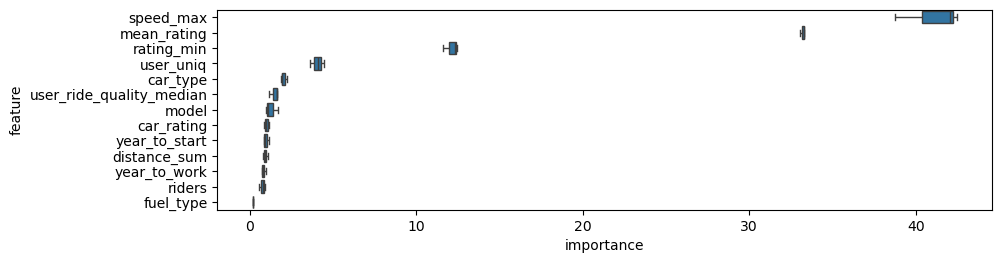

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    best_model = clfs,
    height = 0.20,
    top_n=13,
)

## **`Feature Importance`** с помощью **Shap**

In [19]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

In [20]:
import shap

shap.initjs()

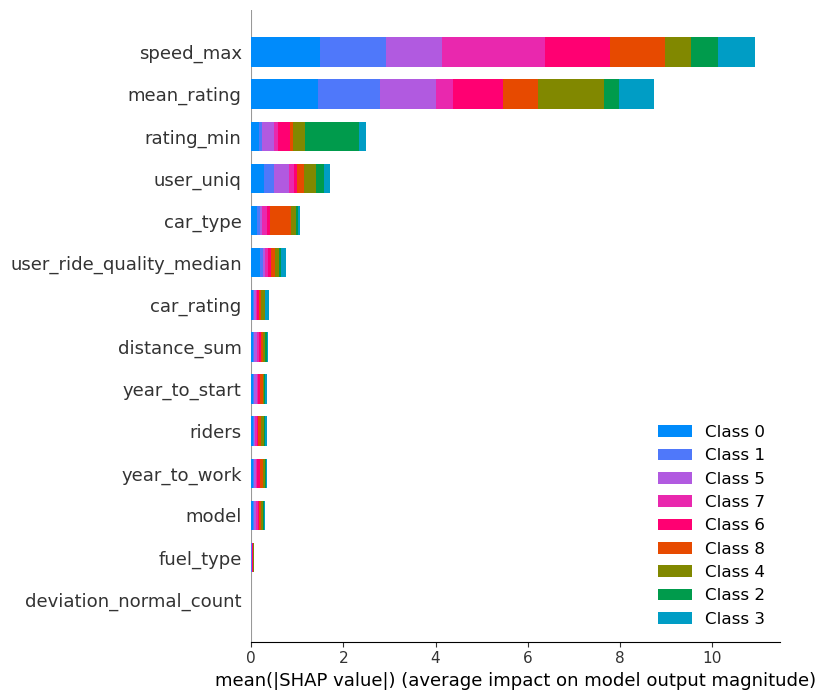

In [21]:
explainer = shap.TreeExplainer(clfs[-1])

train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X_train, max_display=25)

# Теперь произведем инференс модели

In [23]:
path = "quickstart_test.csv"
sub = pd.read_csv(path)

# массив для записи финального прогноза size*n_class
y_pred = np.zeros((sub.shape[0], train[targets].nunique()[0]))

# Пробегаемся по моделям каждого фолда и дергаем прогноз 
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(sub[filtered_features])

f = lambda x: clf.classes_[x]
sub["target_class"] = list(map(f, y_pred.argmax(axis=1)))

sub[["car_id", "target_class"]].to_csv("catboost_kfold.csv", index=False)
sub[["car_id", "target_class"]].head()

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,car_id,target_class
0,P17494612l,engine_overheat
1,N-1530212S,electro_bug
2,B-1154399t,break_bug
3,F12725233R,gear_stick
4,l-1139189J,electro_bug


## **`Object Importance`** или удаляем вредные примеры

    
`**Object importance**` - позволяет оценить влияние каждого элемента обучающей выборки на значение целевой метрики (`eval_metric`). То есть, с помощью этой функции можно найти и избавиться от выбросов, шума и прочего мусора в тренировочном датасете.

На данный момент, расчет **object importance** доступен только для некоторых лосс-функций: 

`Logloss`, `CrossEntropy`, `RMSE`, `MAE`, `Quantile`, `Expectile`, `LogLinQuantile`, `MAPE`, `Poisson`

В списке нет `MultiLogloss`, поэтому для задачи мультиклассификации нельзя его рассчитать. Рассмотрим на примере регрессии.


In [24]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Обучим модель регрессии
model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.056174
0:	learn: 17.0065561	test: 17.7387430	best: 17.7387430 (0)	total: 4.93ms	remaining: 4.93s
100:	learn: 10.5043228	test: 12.2090243	best: 12.2090243 (100)	total: 234ms	remaining: 2.08s
200:	learn: 9.3900288	test: 12.1591227	best: 12.1374989 (148)	total: 411ms	remaining: 1.63s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.1374989
bestIteration = 148

Shrink model to first 149 iterations.


<div class="alert alert-info">
    
Рассмотрим основные параметры метода `get_object_importance`: <br>
```python
get_object_importance(pool,
                      train_pool,
                      top_size=-1, # число возвращаемых наиболее важных объектов из трэйн датасета (-1 без ограничений)
                      type='Average', # тип вычисления `Average` или `PerObject` - второй тип дольше
                      importance_values_sign='All' # `Positive`, `Negative`, `All` - зависит от оптимизируемой метрики
                      update_method='SinglePoint', # `SinglePoint` — быстрейший, `TopKLeaves`, `AllPoints` — Самый медленный и самый точный метод.
                      )
```

In [26]:
# метод возвращает отсортированные списки индексов и скоров
idxs, scores = model.get_object_importance(
    test_pool, train_pool, importance_values_sign="Positive", thread_count=-1
)
len(idxs)

1070

In [27]:
# Нашлось 1070 объектов, которые увеличивают нашу RMSE, посмотрим на топ-20
scores[:20]

[1.0760798660350779,
 0.6217592053237175,
 0.28241900661358055,
 0.24956990727651696,
 0.2473919563486811,
 0.24435693957510338,
 0.22605544242815276,
 0.222093088614638,
 0.21411728044697934,
 0.20855406342759,
 0.20814361321622363,
 0.20165304798163927,
 0.2009990077614598,
 0.20085475767541583,
 0.1902886505182502,
 0.18728240775813945,
 0.18727006159768447,
 0.1854390466216923,
 0.18382276655258728,
 0.1773868133984341]

In [28]:
# Попробуем отбросить топ-100 найденных и посмотрим как изменится точность
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:100]),
    y_train.reset_index(drop=True).drop(idxs[:100]),
    cat_features=cat_features,
)

model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.055692
0:	learn: 16.7940672	test: 17.7337852	best: 17.7337852 (0)	total: 2.67ms	remaining: 2.67s
100:	learn: 9.5267039	test: 11.6210027	best: 11.6210027 (100)	total: 221ms	remaining: 1.97s
200:	learn: 8.5490724	test: 11.6513031	best: 11.5690115 (127)	total: 384ms	remaining: 1.53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 11.56901147
bestIteration = 127

Shrink model to first 128 iterations.


<div class="alert alert-info">
    
`RMSE` уменьшилась на `~ 0.5`. Можете ещё поэкспериментировать с другими параметрами и отбрасыванием большего количества объектов.

## Подбор оптимальных гиперпараметров.

В `CatBoost` реализовано 2 метода подбора гиперпараметров модели: `grid_search` и `randomized_search`. Как заявляют авторы фреймворка, методы оптимизированы и справляются с задачей быстрее, чем аналогичные из `sklearn`. [Grid search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search) просто перебирает параметры по заданной сетке, [randomized search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_randomized_search) берет рандомные сэмплы из заданного распределения.

Посмотрим пример с `randomized search`. В последующих модулях вы узнаете про более быстрые и умные оптимизаторы гиперпараметров, но начать можно с этих. 

In [29]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_features,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

0:	learn: 47.0674623	test: 45.9655438	best: 45.9655438 (0)	total: 3.3ms	remaining: 3.3s
500:	learn: 10.0592927	test: 10.6205356	best: 10.6205356 (500)	total: 754ms	remaining: 751ms
999:	learn: 8.9151340	test: 10.5927770	best: 10.5913618 (997)	total: 1.27s	remaining: 0us

bestTest = 10.59136175
bestIteration = 997

0:	loss: 10.5913618	best: 10.5913618 (0)	total: 1.31s	remaining: 11.8s
0:	learn: 47.0653639	test: 45.9527103	best: 45.9527103 (0)	total: 452us	remaining: 452ms
500:	learn: 12.4029998	test: 11.9040292	best: 11.9040292 (500)	total: 164ms	remaining: 163ms
999:	learn: 11.9554606	test: 11.6941156	best: 11.6933492 (998)	total: 339ms	remaining: 0us

bestTest = 11.69334924
bestIteration = 998

1:	loss: 11.6933492	best: 10.5913618 (0)	total: 1.66s	remaining: 6.63s
0:	learn: 47.0674623	test: 45.9655438	best: 45.9655438 (0)	total: 1.03ms	remaining: 1.03s
500:	learn: 10.6415766	test: 10.7212807	best: 10.7212807 (500)	total: 391ms	remaining: 390ms
999:	learn: 9.8639354	test: 10.6294194	be

{'learn': {'RMSE': 8.978620241596044}}

In [30]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

{'l2_leaf_reg': 2,
 'depth': 4.0,
 'one_hot_max_size': 2.0,
 'learning_rate': 0.03}

# Какие еще полезные параметры есть в **`Catboost`**?

<div class="alert alert-info">

**Многие знают, что такое `random_seed`, `learning_rate`, `iterations`, поэтому обсудим другие:**
* `boosting_type` – тип бустинга, который используется при обучении
  * значение `Plain` дает качество хуже, но работает быстрее
  * есть другой более затратный тип — `Ordered`, но дает лучшее качество (только для небольших датасетов).
* `bootstrap_type` –  определяет метод сэмплинга весов объектов. Когда мы строим дерево, построение идет не по всем объектам обучающей выборки, а по нескольким объектам. Это может быть Байес, Бернулли, многомерная случайная величина или Пуассон.
* `subsample` – вероятность, по которой будет выбираться каждый объект для построения дерева. Параметры `bootstrap_type` и `subsample` идут в связке.
* `one_hot_max_size` – это горячее кодирование определенных переменных выборки (конвертируем каждое категориальное значение в новый категориальный столбец и присваиваем этим столбцам двоичное значение 1 или 0). 
* `RSM` - аналогичен `subsample`, только используется **для фичей, а не объектов**.
* `leaf_estimation_iterations` – количество итераций подсчета значений в листьях.
* `max_ctr_complexity` – длина перебора комбинаций фичей из данной выборки. Разделение ветвей не только по отдельным признакам, **но и по их комбинациям - одна из ключевых особенностей CatBoost.**

In [31]:
from catboost import CatBoost

fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type="Plain",
    bootstrap_type="Bernoulli",
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    # cat_features = cat_features,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    early_stopping_rounds=10,
)

fast_model.fit(
    train_dataset,
    eval_set=eval_dataset,
    verbose=100,
    # plot=True
);

0:	learn: 2.1616973	test: 2.1612391	best: 2.1612391 (0)	total: 20.5ms	remaining: 3.06s
100:	learn: 0.8112038	test: 0.8361220	best: 0.8361220 (100)	total: 1.78s	remaining: 866ms
149:	learn: 0.6690084	test: 0.7050471	best: 0.7050471 (149)	total: 2.67s	remaining: 0us

bestTest = 0.7050471238
bestIteration = 149



# Какие параметры использовались в модели?

In [32]:
fs2noshow = [
  "boosting_type","boosting_type","max_ctr_complexity","leaf_estimation_iterations", "rsm","one_hot_max_size",
    "subsample", "depth","task_type","eval_metric","iterations", "loss_function","min_data_in_leaf",
    "learning_rate", "auto_class_weights","classes_count", "random_seed","l2_leaf_reg",
]

for key, value in fast_model.get_all_params().items():
    if key not in fs2noshow:
        print("{}, {}".format(key, value))

nan_mode, Min
combinations_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=8:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
sampling_frequency, PerTree
fold_permutation_block, 0
leaf_estimation_method, Newton
od_pval, 0
random_score_type, NormalWithModelSizeDecrease
counter_calc_method, SkipTest
grow_policy, SymmetricTree
penalties_coefficient, 1
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
ctr_leaf_count_limit, 18446744073709551615
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
random_strength, 1
od_type, Iter
boost_from_average, False
model_size_reg, 0.5
simple_ctr, ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=8:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
pool_metainfo_options, {'tags': {}}
use_best_model, True
od_wait, 1

# Давайте рассмотрим параметры в **`CatBoost`**, которые еще не обсуждали:

<div class="alert alert-info">
    
**Режимы построения дерева (политика роста)**
    
`grow_policy` – определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении **`SymmetricTree`**, **`Depthwise`** или **`Lossguide`**. По умолчанию **`SymmetricTree`**.
  * **`SymmetricTree`** - дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием.
  * **`Depthwise`** дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь.
  * **`Lossguide`** дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь. lightGBM
    

**Напоминание:**

* `min_data_in_leaf` или `min_child_samples` – это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста **`Lossguide`** и **`Depthwise`**.
* `max_leaves` или `num_leaves` – этот параметр используется только с политикой **`Lossguide`** и определяет количество листьев в дереве.

<div class="alert alert-info">

**Пропуски в численных фичах**
    
* `nan_mode` – метод работы с пропущенными значениями.
  * Параметры **`Forbidden`**, **`Min`** и **`Max`**. 
  * При использовании **`Forbidden`** наличие пропущенных значений вызовет ошибку.
  * При использовании параметра **`Max`**, пропущенные значения будут приняты за **максимальные** значения для данного признака. 
  * При использовании параметра **`Min`**, пропущенные значения будут приняты за **минимальные** значения для данного признака.
    

### ⛄️ Параметров много. Про некоторые из них в другой раз 

<div class="alert alert-info">
    
    
* `score_function` – тип оценки, используемой для выбора следующего разбиения при построении дерева. 
  * **`Cosine`** используется по умолчанию.
  * Другие доступные варианты **`L2`**, **`NewtonL2`** и **`NewtonCosine`**.
    
* `leaf_estimation_backtracking` – тип бэктрекинга, использующийся при градиентном спуске. По умолчанию используется **`AnyImprovement`**. 
  * **`AnyImprovement`** уменьшает шаг спуска до того, как значение функции потерь будет меньшим, чем оно было на последней итерации.
  * **`Armijo`** уменьшает шаг спуска до тех пор, пока не будет выполнено условие Вольфе.
* `text_features` — используется для объявления текстовых столбцов в задачах классификации.

# Сохраняем и подгружаем модель

    
Сохранить обученную модель **`CatBoost`** можно в нескольких форматах - `json`, `cpp`, `onnx`. <br>
Однако, в `CatBoost` есть собственный формат для сохранения моделей `cbm` (**CatBoost binary format**), предпочтительно сохранять модели именно в этом формате.

In [33]:
params = {
    "iterations": 100,
    "learning_rate": 0.001,
    "depth": 7,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.9,
    "random_seed": 7575,
}


clf = CatBoostClassifier(**params)

clf = clf.fit(train_dataset, eval_set=eval_dataset, verbose=False)

print(clf.get_params())

{'iterations': 100, 'learning_rate': 0.001, 'depth': 7, 'random_seed': 7575, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9}


In [34]:
model.save_model("catboost_model.cbm", format="cbm")  # format по умолчанию cbm поэтому можно явно не указывать

Теперь загрузим нашу модель и проверим параметры:

In [35]:
new_clf = CatBoostClassifier()
new_clf.load_model("catboost_model.cbm")

In [36]:
print(new_clf.get_params())

{'eval_metric': 'RMSE', 'verbose': 0, 'one_hot_max_size': 2, 'loss_function': 'RMSE', 'l2_leaf_reg': 2, 'depth': 4, 'random_seed': 42, 'learning_rate': 0.03}
